In [24]:
#Inspired by https://github.com/markroxor (Mohit Rathore)
# Download data
import nltk
nltk.download('brown') 
# popular old school corpus
# Only the brown corpus is needed in case you don't have it.

# Generate brown corpus text file
with open('brown_corp.txt', 'w+') as f:
    for word in nltk.corpus.brown.words():
        f.write('{word} '.format(word=word))

# Make sure you set FT_HOME to your fastText directory root
FT_HOME = 'fastText/'
# download the text8 corpus (a 100 MB sample of cleaned wikipedia text)
import os.path
if not os.path.isfile('text8'):
    !wget -c http://mattmahoney.net/dc/text8.zip
    !unzip text8.zip
# download and preprocess the text9 corpus
if not os.path.isfile('text9'):
  !wget -c http://mattmahoney.net/dc/enwik9.zip
  !unzip enwik9.zip
  !perl {FT_HOME}wikifil.pl enwik9 > text9

[nltk_data] Downloading package 'brown' to
[nltk_data]     /Users/Errazudin/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [14]:
# Train models
# Make sure Gensim and fasttext properly setup
MODELS_DIR = 'models/'
!mkdir -p {MODELS_DIR}

lr = 0.05
dim = 100
ws = 5
epoch = 5
minCount = 5
neg = 5
loss = 'ns'
t = 1e-4

from gensim.models import Word2Vec
from gensim.models.word2vec import Text8Corpus

# Same values as used for fastText training above
params = {
    'alpha': lr,
    'size': dim,
    'window': ws,
    'iter': epoch,
    'min_count': minCount,
    'sample': t,
    'sg': 1,
    'hs': 0,
    'negative': neg
}

def train_models(corpus_file, output_name):
    output_file = '{:s}_ft'.format(output_name)
    if not os.path.isfile(os.path.join(MODELS_DIR, '{:s}.vec'.format(output_file))):
        print('Training fasttext on {:s} corpus..'.format(corpus_file))
        %time !{FT_HOME}fastText skipgram -input {corpus_file} -output {MODELS_DIR+output_file}  -lr {lr} -dim {dim} -ws {ws} -epoch {epoch} -minCount {minCount} -neg {neg} -loss {loss} -t {t}
    else:
        print('\nUsing existing model file {:s}.vec'.format(output_file))
        
    output_file = '{:s}_ft_no_ng'.format(output_name)
    if not os.path.isfile(os.path.join(MODELS_DIR, '{:s}.vec'.format(output_file))):
        print('\nTraining fasttext on {:s} corpus (without char n-grams)..'.format(corpus_file))
        %time !{FT_HOME}fastText skipgram -input {corpus_file} -output {MODELS_DIR+output_file}  -lr {lr} -dim {dim} -ws {ws} -epoch {epoch} -minCount {minCount} -neg {neg} -loss {loss} -t {t} -maxn 0
    else:
        print('\nUsing existing model file {:s}.vec'.format(output_file))
        
    output_file = '{:s}_gs'.format(output_name)
    if not os.path.isfile(os.path.join(MODELS_DIR, '{:s}.vec'.format(output_file))):
        print('\nTraining word2vec on {:s} corpus..'.format(corpus_file))
        
        # Text8Corpus class for reading space-separated words file
        %time gs_model = Word2Vec(Text8Corpus(corpus_file), **params); gs_model
        # Direct local variable lookup doesn't work properly with magic statements (%time)
        locals()['gs_model'].save_word2vec_format(os.path.join(MODELS_DIR, '{:s}.vec'.format(output_file)))
        print('\nSaved gensim model as {:s}.vec'.format(output_file))
    else:
        print('\nUsing existing model file {:s}.vec'.format(output_file))

evaluation_data = {}
train_models('brown_corp.txt', 'brown')

Training fasttext on brown_corp.txt corpus..
Read 1M words
Number of words:  15173
Number of labels: 0
Progress: 100.0%  words/sec/thread: 84969  lr: 0.000000  loss: 2.352019  eta: 0h0m 
CPU times: user 180 ms, sys: 42.8 ms, total: 223 ms
Wall time: 15.7 s

Training fasttext on brown_corp.txt corpus (without char n-grams)..
Read 1M words
Number of words:  15173
Number of labels: 0
Progress: 100.0%  words/sec/thread: 130771  lr: 0.000000  loss: 2.444066  eta: 0h0m 
CPU times: user 122 ms, sys: 32.9 ms, total: 155 ms
Wall time: 8.34 s

Using existing model file brown_gs.vec


In [15]:
train_models(corpus_file='text8', output_name='text8')


Training fasttext on text8 corpus..
Read 17M words
Number of words:  71290
Number of labels: 0
Progress: 100.0%  words/sec/thread: 77248  lr: 0.000000  loss: 1.761736  eta: 0h0m 
CPU times: user 3.93 s, sys: 787 ms, total: 4.71 s
Wall time: 3min

Training fasttext on text8 corpus (without char n-grams)..
Read 17M words
Number of words:  71290
Number of labels: 0
Progress: 100.0%  words/sec/thread: 134470  lr: 0.000000  loss: 1.814462  eta: 0h0m 
CPU times: user 2.72 s, sys: 594 ms, total: 3.31 s
Wall time: 1min 44s

Using existing model file text8_gs.vec


In [16]:
# larger datasets
train_models(corpus_file='text9', output_name='text9')

Training fasttext on text9 corpus..
Read 124M words
Number of words:  218316
Number of labels: 0
Progress: 100.0%  words/sec/thread: 79982  lr: 0.000000  loss: 0.663157  eta: 0h0m 
CPU times: user 44.8 s, sys: 16.3 s, total: 1min 1s
Wall time: 19min 54s

Training fasttext on text9 corpus (without char n-grams)..
Read 124M words
Number of words:  218316
Number of labels: 0
Progress: 100.0%  words/sec/thread: 154618  lr: 0.000000  loss: 0.657629  eta: 0h0m 
CPU times: user 31 s, sys: 11.7 s, total: 42.7 s
Wall time: 10min 16s

Training word2vec on text9 corpus..
CPU times: user 50min 37s, sys: 14.9 s, total: 50min 52s
Wall time: 17min 20s

Saved gensim model as text9_gs.vec


In [17]:
# Compare
# download the file questions-words.txt to be used for comparing word embeddings
!wget https://raw.githubusercontent.com/tmikolov/word2vec/master/questions-words.txt

--2017-12-01 23:48:17--  https://raw.githubusercontent.com/tmikolov/word2vec/master/questions-words.txt
Resolving raw.githubusercontent.com... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68853 (67K) [text/plain]
Saving to: 'questions-words.txt.1'

questions-words.txt 100%[===================>]  67.24K  --.-KB/s    in 0.02s   

2017-12-01 23:48:17 (3.15 MB/s) - 'questions-words.txt.1' saved [603955]



In [18]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Training times in seconds
evaluation_data['brown'] = [(18, 54.3, 32.5)]
evaluation_data['text8'] = [(402, 942, 496)]
evaluation_data['text9'] = [(3218, 6589, 3550)]

def print_accuracy(model, questions_file):
    print('Evaluating...\n')
    acc = model.accuracy(questions_file)

    sem_correct = sum((len(acc[i]['correct']) for i in range(5)))
    sem_total = sum((len(acc[i]['correct']) + len(acc[i]['incorrect'])) for i in range(5))
    sem_acc = 100*float(sem_correct)/sem_total
    print('\nSemantic: {:d}/{:d}, Accuracy: {:.2f}%'.format(sem_correct, sem_total, sem_acc))
    
    syn_correct = sum((len(acc[i]['correct']) for i in range(5, len(acc)-1)))
    syn_total = sum((len(acc[i]['correct']) + len(acc[i]['incorrect'])) for i in range(5,len(acc)-1))
    syn_acc = 100*float(syn_correct)/syn_total
    print('Syntactic: {:d}/{:d}, Accuracy: {:.2f}%\n'.format(syn_correct, syn_total, syn_acc))
    return (sem_acc, syn_acc)

word_analogies_file = 'questions-words.txt'
accuracies = []
print('\nLoading Gensim embeddings')
brown_gs = Word2Vec.load_word2vec_format(MODELS_DIR + 'brown_gs.vec')
print('Accuracy for Word2Vec:')
accuracies.append(print_accuracy(brown_gs, word_analogies_file))

print('\nLoading FastText embeddings')
brown_ft = Word2Vec.load_word2vec_format(MODELS_DIR + 'brown_ft.vec')
print('Accuracy for FastText (with n-grams):')
accuracies.append(print_accuracy(brown_ft, word_analogies_file))


Loading Gensim embeddings
Accuracy for Word2Vec:
Evaluating...


Semantic: 26/813, Accuracy: 3.20%
Syntactic: 105/5255, Accuracy: 2.00%


Loading FastText embeddings
Accuracy for FastText (with n-grams):
Evaluating...


Semantic: 49/813, Accuracy: 6.03%
Syntactic: 2566/5255, Accuracy: 48.83%



In [19]:
print('Loading FastText embeddings')
brown_ft_no_ng = Word2Vec.load_word2vec_format(MODELS_DIR + 'brown_ft_no_ng.vec')
print('Accuracy for FastText (without n-grams):')
accuracies.append(print_accuracy(brown_ft_no_ng, word_analogies_file))
evaluation_data['brown'] += [[acc[0] for acc in accuracies], [acc[1] for acc in accuracies]]

Loading FastText embeddings
Accuracy for FastText (without n-grams):
Evaluating...


Semantic: 32/813, Accuracy: 3.94%
Syntactic: 102/5255, Accuracy: 1.94%



In [20]:
accuracies = []
print('Loading Gensim embeddings')
text8_gs = Word2Vec.load_word2vec_format(MODELS_DIR + 'text8_gs.vec')
print('Accuracy for word2vec:')
accuracies.append(print_accuracy(text8_gs, word_analogies_file))

print('Loading FastText embeddings (with n-grams)')
text8_ft = Word2Vec.load_word2vec_format(MODELS_DIR + 'text8_ft.vec')
print('Accuracy for FastText (with n-grams):')
accuracies.append(print_accuracy(text8_ft, word_analogies_file))

print('Loading FastText embeddings')
text8_ft_no_ng = Word2Vec.load_word2vec_format(MODELS_DIR + 'text8_ft_no_ng.vec')
print('Accuracy for FastText (without n-grams):')
accuracies.append(print_accuracy(text8_ft_no_ng, word_analogies_file))

evaluation_data['text8'] += [[acc[0] for acc in accuracies], [acc[1] for acc in accuracies]]

Loading Gensim embeddings
Accuracy for word2vec:
Evaluating...


Semantic: 1636/4103, Accuracy: 39.87%
Syntactic: 3407/8165, Accuracy: 41.73%

Loading FastText embeddings (with n-grams)
Accuracy for FastText (with n-grams):
Evaluating...


Semantic: 1463/4052, Accuracy: 36.11%
Syntactic: 5559/8165, Accuracy: 68.08%

Loading FastText embeddings
Accuracy for FastText (without n-grams):
Evaluating...


Semantic: 1658/4052, Accuracy: 40.92%
Syntactic: 3304/8165, Accuracy: 40.47%



In [21]:
#Larger corpus

accuracies = []
print('Loading Gensim embeddings')
text9_gs = Word2Vec.load_word2vec_format(MODELS_DIR + 'text9_gs.vec')
print('Accuracy for word2vec:')
accuracies.append(print_accuracy(text9_gs, word_analogies_file))

print('Loading FastText embeddings (with n-grams)')
text9_ft = Word2Vec.load_word2vec_format(MODELS_DIR + 'text9_ft.vec')
print('Accuracy for FastText (with n-grams):')
accuracies.append(print_accuracy(text9_ft, word_analogies_file))

print('Loading FastText embeddings')
text9_ft_no_ng = Word2Vec.load_word2vec_format(MODELS_DIR + 'text9_ft_no_ng.vec')
print('Accuracy for FastText (without n-grams):')
accuracies.append(print_accuracy(text9_ft_no_ng, word_analogies_file))

evaluation_data['text9'] += [[acc[0] for acc in accuracies], [acc[1] for acc in accuracies]]

Loading Gensim embeddings
Accuracy for word2vec:
Evaluating...


Semantic: 2830/4833, Accuracy: 58.56%
Syntactic: 4958/8311, Accuracy: 59.66%

Loading FastText embeddings (with n-grams)
Accuracy for FastText (with n-grams):
Evaluating...


Semantic: 2477/4833, Accuracy: 51.25%
Syntactic: 5612/8311, Accuracy: 67.52%

Loading FastText embeddings
Accuracy for FastText (without n-grams):
Evaluating...


Semantic: 2613/4833, Accuracy: 54.07%
Syntactic: 4900/8311, Accuracy: 58.96%



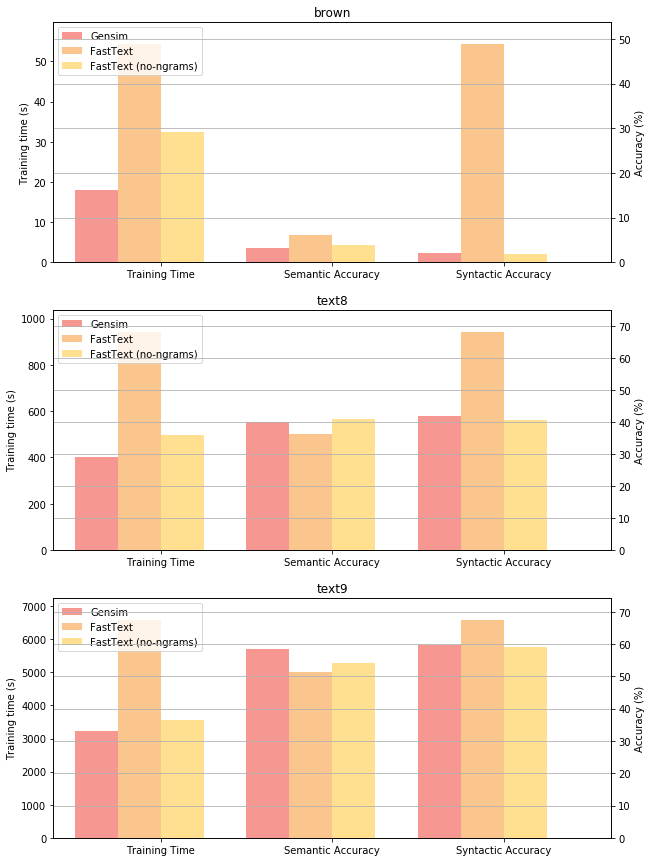

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot(ax, data, corpus_name='brown'):
    width = 0.25
    pos = [(i, i + width, i + 2*width) for i in range(len(data))]
    colors = ['#EE3224', '#F78F1E', '#FFC222']
    acc_ax = ax.twinx()
    # Training time
    ax.bar(pos[0],
            data[0],
            width,
            alpha=0.5,
            color=colors
            )
    # Semantic accuracy
    acc_ax.bar(pos[1],
            data[1],
            width,
            alpha=0.5,
            color=colors
            )

    # Syntactic accuracy
    acc_ax.bar(pos[2],
            data[2],
            width,
            alpha=0.5,
            color=colors
            )

    ax.set_ylabel('Training time (s)')
    acc_ax.set_ylabel('Accuracy (%)')
    ax.set_title(corpus_name)

    acc_ax.set_xticks([p[0] + 1.5 * width for p in pos])
    acc_ax.set_xticklabels(['Training Time', 'Semantic Accuracy', 'Syntactic Accuracy'])

    # Proxy plots for adding legend correctly
    proxies = [ax.bar([0], [0], width=0, color=c, alpha=0.5)[0] for c in colors]
    models = ('Gensim', 'FastText', 'FastText (no-ngrams)')
    ax.legend((proxies), models, loc='upper left')
    
    ax.set_xlim(pos[0][0]-width, pos[-1][0]+width*4)
    ax.set_ylim([0, max(data[0])*1.1] )
    acc_ax.set_ylim([0, max(data[1] + data[2])*1.1] )

    plt.grid()

# Plotting the bars
fig = plt.figure(figsize=(10,15))
for corpus, subplot in zip(sorted(evaluation_data.keys()), [311, 312, 313]):
    ax = fig.add_subplot(subplot)
    plot(ax, evaluation_data[corpus], corpus)

plt.show()